<a href="https://colab.research.google.com/github/Spookytober/Datascience/blob/main/AO_Unit7ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting Curves: Concepts

What you'll do:

- Answer questions about what a GP is, and its relationship to GLMs and splines.
- Practice applying one of: polynomial modeling, b splines, or GPs
- You'll get a chance to read about and try to comprehend a more standard implementation of a GP.

Have fun!

**Task1**:

Why would you ever want to include a polynomial element in a model you built? What's the benefit of using polynomials to model?

Polynomials allow for curvature in your model. A GLM just forms a straight line. If your data does not necessarily follow a straight line, a polynomial is far better to use. If you have a repeating set of data points, like hours of the day, and don't have to worry about overfitting, polynomials are also great, because they more accurately predict than a straight line.

**Task2**:

Why would you ever NOT want to include a polynomial element in a model you built?

You wouldn't want to use a polynomial with a dataset that formed a straight line. If there is a direct correlation between predictor and predicted, forming a line that could be modeled with a GLM, a polynomial element might not be best. This is because the polynomial will curve more, adding the possibility of overfitting as it will follow the path of the data points instead of the general trend.

**Task3**:

What's the point of using b splines?

B splines can help to make a smooth curve that follows your data. By splitting the data up into sections and applying a polynomial to each piece, you can get really great control over your model. You can also tell your model which area of the data has more effect. You have to choose knots.

**Task4**:

Describe what a Gaussian Process is, in your own words. *Don't worry about being correct, just try to explain it to yourself*. I will not grade this question for accuracy.

A GP is a process that compares the relationships of each data point to each other. It considers every single data point and its relation to the other data points, the ones right next to it and the points farthest away from it. Points that are closer together have a stronger correlation. They create a distribution based on these relationships that can perform better than a polynomial can, unless the data is already like a polynomial.

**Task5**:

Refit a model to the howell data, using one of the following: polynomial model, b splines, or GPs.
Plot the posterior predictive check on a scatter plot

You only need to use one . Remember, the simpler the model is, the better (usually).

Hint: If you use a polynomial or bspline, try a disdributional model


In [1]:
!pip install git+https://github.com/pydata/xarray.git
!pip install preliz
!pip install bambi
import preliz as pz
import bambi as bmb
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-6equ81_n
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-6equ81_n
  Resolved https://github.com/pydata/xarray.git to commit 4bbab48cacf94ff285475bd7b7abeea3b2ea888f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.3.dev16+g4bbab48c-py3-none-any.whl size=1255523 sha256=6831794078e003bef221f7e873a178aeed728d8ae7bacb4566aea621a5d97eaf
  Stored in directory: /tmp/pip-ephem-wheel-cache-w4xua8sh/wheels/15/f9/46/ac58ec95d7761bd0b92f54d99c5d132719866f63745c3702ed
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.2
    Uninstalling xarray-2025.1.2:
      Successfully uninstalled xarray-2025.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.0 MB/s eta 0:00:00
   ━

In [2]:
howell = pd.read_csv("https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/howell.csv")
height = howell["height"].values
weight = howell["weight"].values[:,None]

In [ ]:
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [ ]:
with pm.Model() as model_hsgp_howell:
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(weight))
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.HSGP(m=[10], c=1.5, cov_func=cov)
    f = gp.prior('f', X=weight)
    α = pm.HalfNormal('α', 1)
    y = pm.NegativeBinomial("y", np.exp(f), α, observed=height)
    idata_hsgp = pm.sample()

Output()

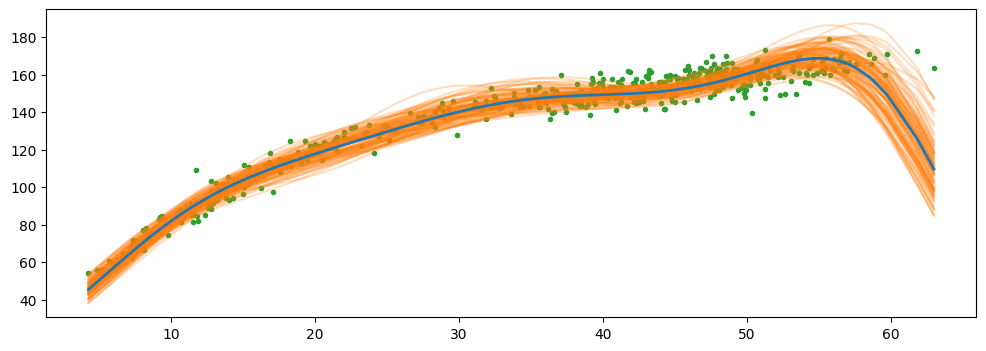

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(howell["weight"].values, howell["height"].values, "C2.")
f = az.extract(idata_hsgp, group="posterior", var_names="f")
idx = np.argsort(howell["weight"].values)
ax.plot(howell["weight"].values[idx], np.exp(f.values[idx,:100]), alpha=0.25, color="C1")
ax.plot(howell["weight"].values[idx], np.exp(f.values[idx].mean(1)), color="C0", lw=2)

That's weird. The graph went way down in the end. I'd guess it's because of the decrease in data points. The last few points also seem to be heading downward slightly in comparison to the rest of the data, which might be why the graph went down.

In [3]:
model_poly_4 = bmb.Model("height ~ poly(weight, degree=4)", howell, family="negativebinomial")
idata_poly_4 = model_poly_4.fit()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


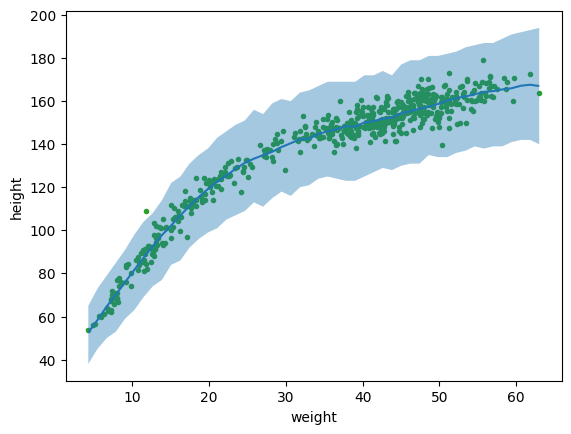

In [4]:
bmb.interpret.plot_predictions(model_poly_4, idata_poly_4, "weight", pps=True)
plt.plot(howell.weight, howell.height, "C2.", zorder=-3)

I think the polynomial performs better than the GP. This graph can be modeled somewhat simply with a polynomial model, it doesn't need too much. It doesnt have the problem of going down at the end.

**Task6**:

Read the article on the pymc website about GP implementation on the Mauna Loa CO$_{2}$ data combined with CO$_{2}$ ice core data from the south pole.
[Link here.](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MaunaLoa2.html)

Write down one thing you learned about GPs from reading the article.

Note: You probably won't understand anything in this article. The main point of this task is to hammer home that good GP implementations are extremely technical.

I learned that changepoints are another word for knots, and that there are ways to choose changepoints with a program instead of just choosing them manually. I believe that is what a Gaussian Process is, pretty much.

**Task7**:

Describe your favorite graph from the article in the previous task. Explain why its your favorite.

I think my favorite graph is the heavyside step function. I'll be honest, even after a half dozen reads, I still don't understand the full meaning of the graph. I know it's meant to choose knots in some way, but that's about it. I understood that they added a smooth curve to it in order to make make the model not jump at x=40, and I like the look of the graph after that curve is added.